In [2]:
libs <- c(
    'dplyr',
    'tidyr',
    'stringr',
    'ggplot2',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")
source("~/git-repos/BDDS/footprints/testdb/src/dbFunctions.R")

In [3]:
load("/local/rory/all.TF.fimo.samples.ratio.49.df.RData")

In [5]:
db_lymph_hint <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              dbname="lymphoblast_hint",
                              host="whovian",
                              port="5432")
db_lymph_well <- src_postgres(drv=dbDriver("PostgreSQL"),
                              user="trena",
                              password="trena",
                              dbname="lymphoblast_wellington",
                              host="whovian",
                              port="5432")
hint_regions <- tbl(db_lymph_hint, "regions")
hint_hits    <- tbl(db_lymph_hint, "hits")
well_regions <- tbl(db_lymph_well, "regions")
well_hits    <- tbl(db_lymph_well, "hits")

## function to loop over all chromosomes

In [6]:
merge_fimo_hint_wellington_one_chrom <- function(chrom_str,
                                                 fimo_tbl,
                                                 hint_regions_tbl,
                                                 hint_hits_tbl,
                                                 well_regions_tbl,
                                                 well_hits_tbl
                                                ) {
    
    # some tables use chr22 and some just use 22
    chrom_long_str = paste("chr",chrom_str, sep="")
    
    # select one chromosome from my data table
    fimo_tbl %>%
    filter(chrom==chrom_str) %>%
    select(-empty) ->
    chrom_all_tf_df
    
    # select one chromosome from hint
    hint_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(hint_hits_tbl, by="loc") %>%
    as.data.frame %>%
    as.tbl %>%
    select(start, endpos, strand, name, score1) %>%
    rename("score1"="h_score") ->
    chrom_hint_all_tbl

    # select one chromosome from wellington
    well_regions_tbl %>%
    filter(chrom==chrom_long_str) %>%
    left_join(well_hits_tbl, by="loc") %>%
    as.data.frame %>%
    as.tbl %>%
    select(start, endpos, strand, name, score1) %>%
    rename("score1"="w_score") ->
    chrom_well_all_tbl
    
    # keep only max hint score but count total nontrivial scores
    chrom_hint_all_tbl %>%
    group_by(start, endpos, name, strand) %>%
    mutate(h_count = n()) %>%
    group_by(start, endpos, name, strand) %>%
    mutate(h_max_score = max(h_score)) %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) %>%
    select(-h_score) ->
    chrom_hint_unique_tbl

    # keep only min wellington score but count total nontrivial scores
    chrom_well_all_tbl %>%
    group_by(start, endpos, name, strand) %>%
    mutate(w_count = n()) %>%
    group_by(start, endpos, name, strand) %>%
    mutate(w_min_score = min(w_score)) %>%
    distinct(start, endpos, name, strand, .keep_all = TRUE) %>%
    select(-w_score) ->
    chrom_well_unique_tbl
    
    # merge hint and wellington into my table
    chrom_all_tf_df %>%
    left_join(chrom_hint_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    left_join(chrom_well_unique_tbl, by=c("start", "endpos", "strand", "motifname"="name")) %>%
    replace_na(list(h_count=0, w_count=0, h_max_score=0, w_min_score=0)) ->
    chrom_all_tf_df_merged
    
    return(chrom_all_tf_df_merged)
    
}

## Perform loop over all chromosomes

In [7]:
big_df <- tibble()

for (chr_str in as.character(1:22)) {
    message(paste("working on chromosome",chr_str))
    
    df <- merge_fimo_hint_wellington_one_chrom(chr_str,
                                               all.TF.df,
                                               hint_regions,
                                               hint_hits,
                                               well_regions,
                                               well_hits)
    big_df <- rbind(big_df, df)
}

working on chromosome 1
working on chromosome 2
working on chromosome 3
working on chromosome 4
working on chromosome 5
working on chromosome 6
working on chromosome 7
working on chromosome 8
working on chromosome 9
working on chromosome 10
working on chromosome 11
working on chromosome 12
working on chromosome 13
working on chromosome 14
working on chromosome 15
working on chromosome 16
working on chromosome 17
working on chromosome 18
working on chromosome 19
working on chromosome 20
working on chromosome 21
working on chromosome 22


In [12]:
str(big_df)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	66231528 obs. of  13 variables:
 $ motifname  : chr  "MA0150.2" "MA0591.1" "MA0492.1" "MA0492.1" ...
 $ chrom      : chr  "1" "1" "1" "1" ...
 $ start      : int  1677938 1677939 1828558 2255789 2255823 2255891 2255917 2255949 2255916 2255983 ...
 $ endpos     : int  1677952 1677953 1828572 2255803 2255837 2255905 2255931 2255963 2255929 2255997 ...
 $ strand     : chr  "+" "+" "-" "-" ...
 $ motifscore : num  13.21 11.66 9.72 13.72 13.72 ...
 $ pval       : num  1.21e-05 1.36e-05 9.18e-05 1.49e-05 1.49e-05 1.49e-05 8.32e-06 1.49e-05 6.42e-05 1.49e-05 ...
 $ sequence   : chr  "CACTGTGACTCCGCA" "ACTGTGACTCCGCAG" "TTTTGTGAGGTCACT" "GGAAATGAGGTCAGG" ...
 $ cs_hit     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ h_count    : num  4 3 2 1 5 2 2 3 2 4 ...
 $ h_max_score: num  309 64 95 19 277 61 61 177 61 49 ...
 $ w_count    : num  2 1 1 3 2 2 4 1 5 2 ...
 $ w_min_score: num  -33.02 -13.5 -3.23 -10.11 -8.62 ...


## Rename and save

In [9]:
all.TF.df.fimo.hint.well <- big_df
save(all.TF.df.fimo.hint.well, file="/local/rory/all.TF.df.fimo.hint.well.49.Rdata")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


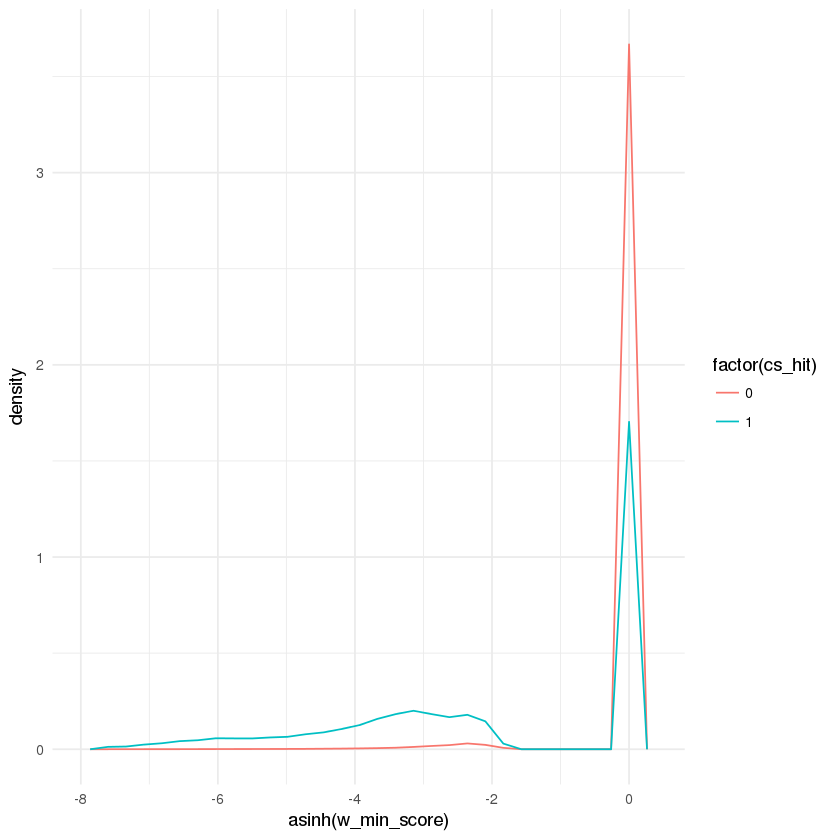

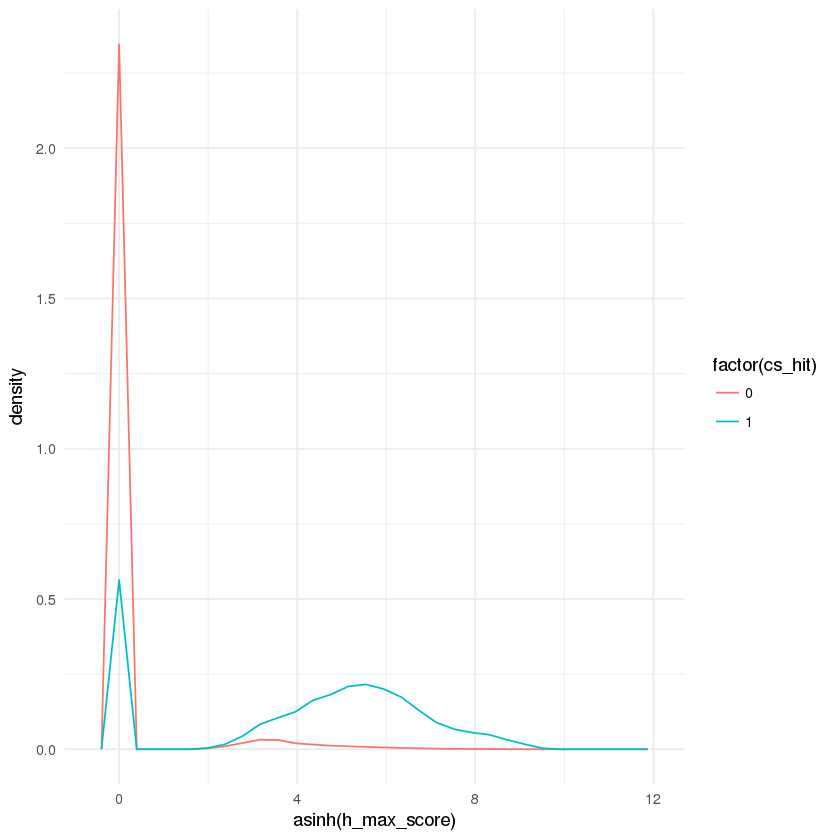

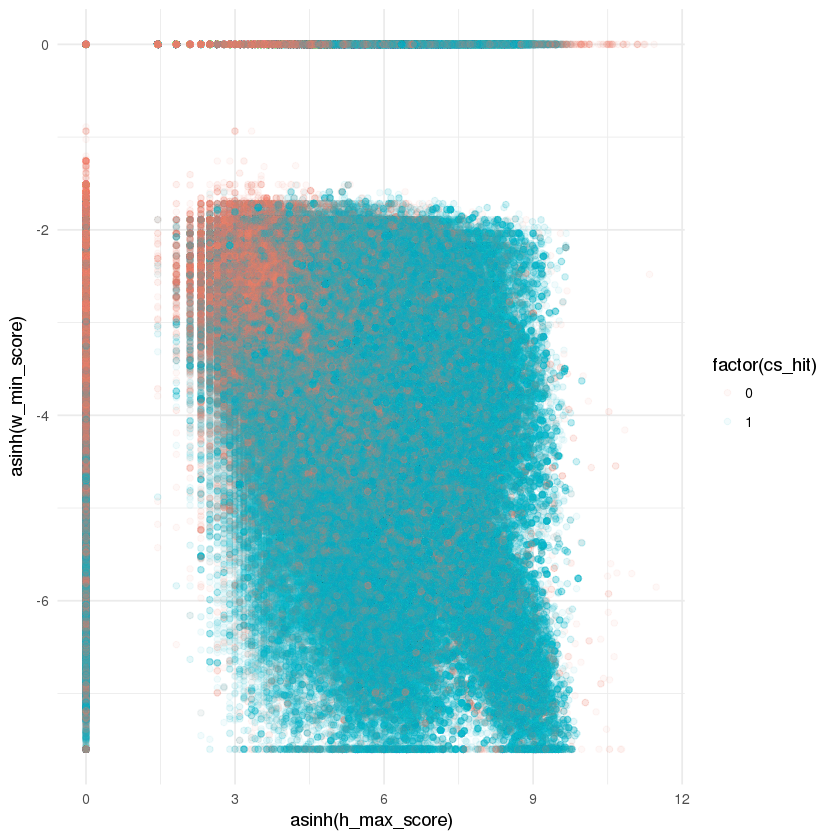

In [13]:
all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(w_min_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_freqpoly(aes(x=asinh(h_max_score), y= ..density.., color=factor(cs_hit))) +
theme_minimal()

all.TF.df.fimo.hint.well %>%
ggplot +
geom_point(
    aes(x=asinh(h_max_score),
        y=asinh(w_min_score),
        color=factor(cs_hit)),
    alpha=0.05) +
theme_minimal()